## Задание на мультиколлинеарность в ансамблях деревьев

Сегодня в домашнем задании вместе с вами разберем популярный миф что мультиколлинеарность фичей никак не аффектит алгоритмы, основанные на ансамблях деревьев

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
import math

rng = np.random.default_rng(seed=121)
random_state = 121
n_features = 10
n_samples = 20_000

# создадим датасет для классификации
x, y = make_classification(n_samples=n_samples, random_state=random_state, n_features=n_features)
df = pd.DataFrame(x, columns=[f'feature_{k}' for k in range(n_features)])
df['target'] = y

Введем пару фичей с мультиколлинеарностью

In [2]:
df['golden_feature_1'] = df['target'] + rng.normal(size = len(y), scale = 0.4) # здесь шума добавили побольше -- фича будет послабее
df['golden_feature_2'] = df['target'] + df['golden_feature_1']  + rng.normal(size = len(y), scale = 0.35)#  здесь шума добавили поменьше -- фича будет посильнее

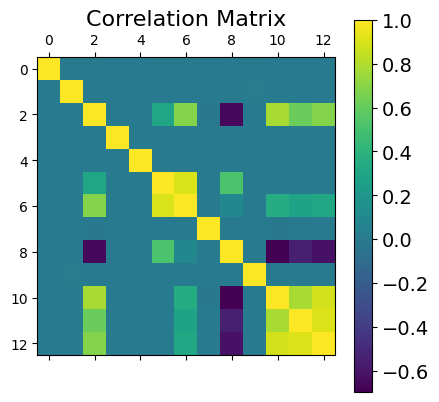

In [3]:
import matplotlib.pyplot as plt

plt.matshow(df.corr())
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

Посмотрим на правый нижний квадрат

<Axes: >

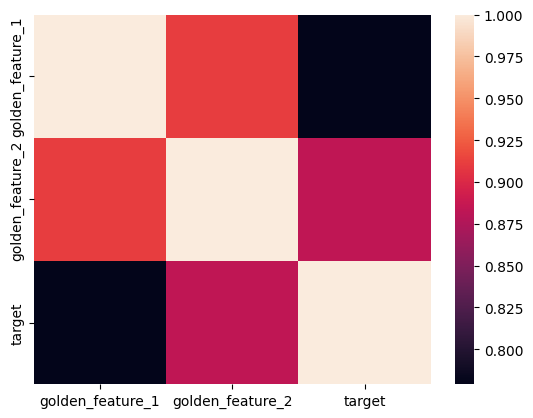

In [4]:
import seaborn as sns
corr = df[['golden_feature_1','golden_feature_2','target']].corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Как видим, обе golgen features сильно скоррелированы между собой и с таргетом (по построению)

### Random Forest

Давайте попробуем обучить RandomForest

Как вы думаете, вот эти сильно скоррелированные между собой и с таргетом фичи где расположатся по важности для модели?

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 20, max_features = 0.5, random_state = random_state)
rf.fit(df.drop('target', axis = 1), y)

RandomForestClassifier(max_depth=20, max_features=0.5, random_state=121)

In [7]:
from tabulate import tabulate
from operator import itemgetter
t = []
for feature, importance in zip(df.drop('target', axis = 1).columns, rf.feature_importances_):
  t.append([feature, importance])
t = sorted(t, reverse = True, key = itemgetter(1))
print(tabulate(t, headers = ['Признак', 'Важность']))

Признак             Важность
----------------  ----------
golden_feature_2  0.607862
feature_2         0.176073
golden_feature_1  0.114753
feature_8         0.0741608
feature_6         0.0101138
feature_5         0.00778537
feature_0         0.00179993
feature_3         0.00170889
feature_7         0.00146428
feature_9         0.00145848
feature_4         0.00143497
feature_1         0.00138557


Неожиданно, правда?      
Или нет?

Сохранится ли такой эффект при изменении max_features?

In [8]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 20, max_features = 0.9, random_state = random_state)
rf.fit(df.drop('target', axis = 1), y)

from tabulate import tabulate
from operator import itemgetter
t = []
for feature, importance in zip(df.drop('target', axis = 1).columns, rf.feature_importances_):
  t.append([feature, importance])
t = sorted(t, reverse = True, key = itemgetter(1))
print(tabulate(t, headers = ['Признак', 'Важность']))

Признак             Важность
----------------  ----------
golden_feature_2  0.835539
feature_2         0.102261
feature_8         0.042239
feature_5         0.00473362
golden_feature_1  0.00371812
feature_6         0.00256499
feature_0         0.00169325
feature_3         0.00163647
feature_4         0.00143691
feature_1         0.00140603
feature_9         0.00140039
feature_7         0.00137217


**Вопрос для теста** -- на каком месте окажется golden_feature_1 при max_features = 0.9?



1.   втором
2.   третьем
3.   четвертом
#4.   пятом
5.   восьмом

Ответ. на 5 месте




Хотя простая корреляционная матрица дает другие числа

In [9]:
df[['golden_feature_1','golden_feature_2','target']].corr()

,golden_feature_1,golden_feature_2,target
golden_feature_1,1.000000,0.910394,0.779165
golden_feature_2,0.910394,1.000000,0.883246
target,0.779165,0.883246,1.000000


Как проверить еще что golden_feature_1 действительно важная?

Обучить RF без ее подруги!


In [10]:
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate
from operator import itemgetter

rf = RandomForestClassifier(n_estimators=100, max_depth=20, max_features=0.9, random_state=random_state)
rf.fit(df.drop(['target', 'golden_feature_2'], axis=1), y)
t = []
for feature, importance in zip(df.drop(['target', 'golden_feature_2'], axis=1).columns, rf.feature_importances_):
    t.append([feature, importance])
t = sorted(t, reverse=True, key=itemgetter(1))

print(tabulate(t, headers=['Признак', 'Важность']))

Признак             Важность
----------------  ----------
feature_2         0.605594
golden_feature_1  0.215889
feature_8         0.131145
feature_5         0.0130605
feature_6         0.00774722
feature_0         0.00467528
feature_4         0.00464695
feature_9         0.00454185
feature_7         0.00430285
feature_1         0.00422526
feature_3         0.00417155


**Вопрос для теста** -- на каком месте по важности окажется фича golden_feature_1 если обучить Random Forest с max_features = 0.9 на датасете без фичи golden_feature_2?



1.   первом
#2.   втором
3.   третьем
4.   четвертом
5.   пятом
6.   восьмом
Ответ на втором месте


### Extremal Gradient Boosting

убедимся что в бустинге будет тот же эффект

In [11]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, colsample_bytree = 0.5, random_state = 43)

In [12]:
xgb.fit(df.drop('target', axis = 1), y)
t = []
for feature, importance in zip(df.drop('target', axis = 1).columns, xgb.feature_importances_):
  t.append([feature, importance])
t = sorted(t, reverse = True, key = itemgetter(1))
print(tabulate(t, headers = ['Признак', 'Важность']))

Признак             Важность
----------------  ----------
golden_feature_2  0.619467
feature_2         0.221745
feature_8         0.0638065
golden_feature_1  0.0492883
feature_6         0.0170231
feature_5         0.0134591
feature_9         0.00279441
feature_3         0.0027107
feature_7         0.00263437
feature_4         0.00243511
feature_0         0.00234785
feature_1         0.00228789


Давайте повторим эксперимент аналогично RF

In [13]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, colsample_bytree = 1.0, random_state = 43)

xgb.fit(df.drop('target', axis = 1), y)
t = []
for feature, importance in zip(df.drop('target', axis = 1).columns, xgb.feature_importances_):
  t.append([feature, importance])
t = sorted(t, reverse = True, key = itemgetter(1))
print(tabulate(t, headers = ['Признак', 'Важность']))

Признак             Важность
----------------  ----------
golden_feature_2  0.835641
feature_8         0.0562887
feature_2         0.055019
feature_5         0.0133256
feature_6         0.00698487
golden_feature_1  0.00582277
feature_3         0.00516934
feature_9         0.00475428
feature_1         0.00455164
feature_0         0.00439369
feature_7         0.00408448
feature_4         0.00396448


**Вопрос для теста** -- на каком месте окажется golden_feature_1 при colsample_bytree = 1.0?



1.   втором
2.   третьем
3.   четвертом
4.   пятом
#5.   шестом
6.   восьмом

Ответ на 6 месте

Давайте посмотрим что произойдет без "подруги" -- фичи golden_feature_2

In [15]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, colsample_bytree = 1.0, random_state = 43)

xgb.fit(df.drop(['target','golden_feature_2'], axis = 1), y)
t = []
for feature, importance in zip(df.drop(['target', 'golden_feature_2'], axis = 1).columns, xgb.feature_importances_):
  t.append([feature, importance])
t = sorted(t, reverse = True, key = itemgetter(1))
print(tabulate(t, headers = ['Признак', 'Важность']))

Признак             Важность
----------------  ----------
feature_2         0.72251
feature_8         0.11547
golden_feature_1  0.101766
feature_5         0.0138126
feature_6         0.0092117
feature_0         0.00706574
feature_1         0.00642251
feature_3         0.00633196
feature_9         0.00609246
feature_7         0.00598582
feature_4         0.00533143


**Вопрос для теста** -- на каком месте окажется golden_feature_1 при обучении на датасете без golden_feature_2 с параметром colsample_bytree = 1.0?


1.   первом
2.   втором
#3.   третьем
4.   четвертом
5.   пятом
6.   восьмом
Ответ на третьем месте

## Регуляризация

Давайте посмотрим что произойдет если мы с мультиколлинерностью будем бороться классическим приемом -- регуляризацией

In [ ]:
for reg_lambda in [0.1, 1, 5, 10, 30, 60, 100, 500, 1000]:
  # INSERT YOUR CODE HERE
  pass

In [18]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, colsample_bytree = 1.0, reg_lambda = 1000, random_state = 43)

xgb.fit(df.drop('target', axis = 1), y)
t = []
for feature, importance in zip(df.drop('target', axis = 1).columns, xgb.feature_importances_):
  t.append([feature, importance])
t = sorted(t, reverse = True, key = itemgetter(1))
print(tabulate(t, headers = ['Признак', 'Важность']))


Признак              Важность
----------------  -----------
golden_feature_2  0.83091
feature_2         0.114693
feature_8         0.0519474
feature_6         0.00141991
feature_5         0.000474385
feature_3         0.00020042
feature_1         0.000103214
feature_7         7.09503e-05
feature_0         5.29003e-05
golden_feature_1  5.09226e-05
feature_4         4.52857e-05
feature_9         3.10408e-05


In [17]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, colsample_bytree = 1.0, reg_lambda = 1000, random_state = 43)

xgb.fit(df.drop(['target','golden_feature_2'], axis = 1), y)
t = []
for feature, importance in zip(df.drop(['target', 'golden_feature_2'], axis = 1).columns, xgb.feature_importances_):
  t.append([feature, importance])
t = sorted(t, reverse = True, key = itemgetter(1))
print(tabulate(t, headers = ['Признак', 'Важность']))

Признак              Важность
----------------  -----------
golden_feature_2  0.83091
feature_2         0.114693
feature_8         0.0519474
feature_6         0.00141991
feature_5         0.000474385
feature_3         0.00020042
feature_1         0.000103214
feature_7         7.09503e-05
feature_0         5.29003e-05
golden_feature_1  5.09226e-05
feature_4         4.52857e-05
feature_9         3.10408e-05


**Вопрос для теста** -- на каком месте окажется golden_feature_1 при обучении  с параметрами colsample_bytree = 1.0 и reg_lambda = 1000?


1.   первом
2.   втором
3.   третьем
4.   четвертом
5.   пятом
6.   восьмом
7.   десятом

#В задании не сказано использовать ли признак golden_feature_2

Поэтому ответ двойной

а) без golden_feature_2: golden_feature_1 на второй позиции

б) с golden_feature_2: golden_feature_1 на ДЕСЯТОЙ позиции (минимальная важность )

Как менялась важность фичи с ростом коэффицента L2-регуляризации?

____

Вывод который можно сделать -- по возможности проблему мультиколлинеарных фичей решат через feature engineering

#Тут опять ничего не сказано про golden_feature_2. Здесь сделаю по своему усмотрению. Без golden_feature_2

думаю в коде нижу есть исчерпывающий ответ на этот вопрос

In [19]:
for reg_lambda in [0.1, 1, 5, 10, 30, 60, 100, 500, 1000]:
    # INSERT YOUR CODE HERE
    from xgboost import XGBClassifier
    xgb = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, colsample_bytree=1.0, reg_lambda=reg_lambda, random_state=43)

    xgb.fit(df.drop(['target','golden_feature_2'], axis=1), y)
    t = []
    for feature, importance in zip(df.drop(['target', 'golden_feature_2'], axis=1).columns, xgb.feature_importances_):
        t.append([feature, importance])
    t = sorted(t, reverse=True, key=itemgetter(1))
    print(f"\n=== reg_lambda = {reg_lambda} ===")
    print(tabulate(t, headers=['Признак', 'Важность']))

    for i, (feature, importance) in enumerate(t, 1):
        if feature == 'golden_feature_1':
            print(f"golden_feature_1 на {i} месте с важностью {importance:.4f}")
            break


=== reg_lambda = 0.1 ===
Признак             Важность
----------------  ----------
feature_2         0.70846
feature_8         0.122006
golden_feature_1  0.098222
feature_5         0.0157631
feature_6         0.0105759
feature_0         0.00829206
feature_3         0.00777104
feature_1         0.00760653
feature_9         0.00754826
feature_4         0.00697843
feature_7         0.00677649
golden_feature_1 на 3 месте с важностью 0.0982

=== reg_lambda = 1 ===
Признак             Важность
----------------  ----------
feature_2         0.72251
feature_8         0.11547
golden_feature_1  0.101766
feature_5         0.0138126
feature_6         0.0092117
feature_0         0.00706574
feature_1         0.00642251
feature_3         0.00633196
feature_9         0.00609246
feature_7         0.00598582
feature_4         0.00533143
golden_feature_1 на 3 месте с важностью 0.1018

=== reg_lambda = 5 ===
Признак             Важность
----------------  ----------
feature_2         0.727156
feature_8   

**Задание**

Кстати, а в бустинге на что (на какие веса) накладывает ограничения L2-регуляризация?

*   Веса деревьев
*   Веса листьев
*   Веса корней
*   Веса веток
*   Веса белок


#Ну конечно же на веса белок сомнений нет

Ответ конечно же веса листьев. Потому что все остальное подается наперед в гиперпараметрах при обучении.

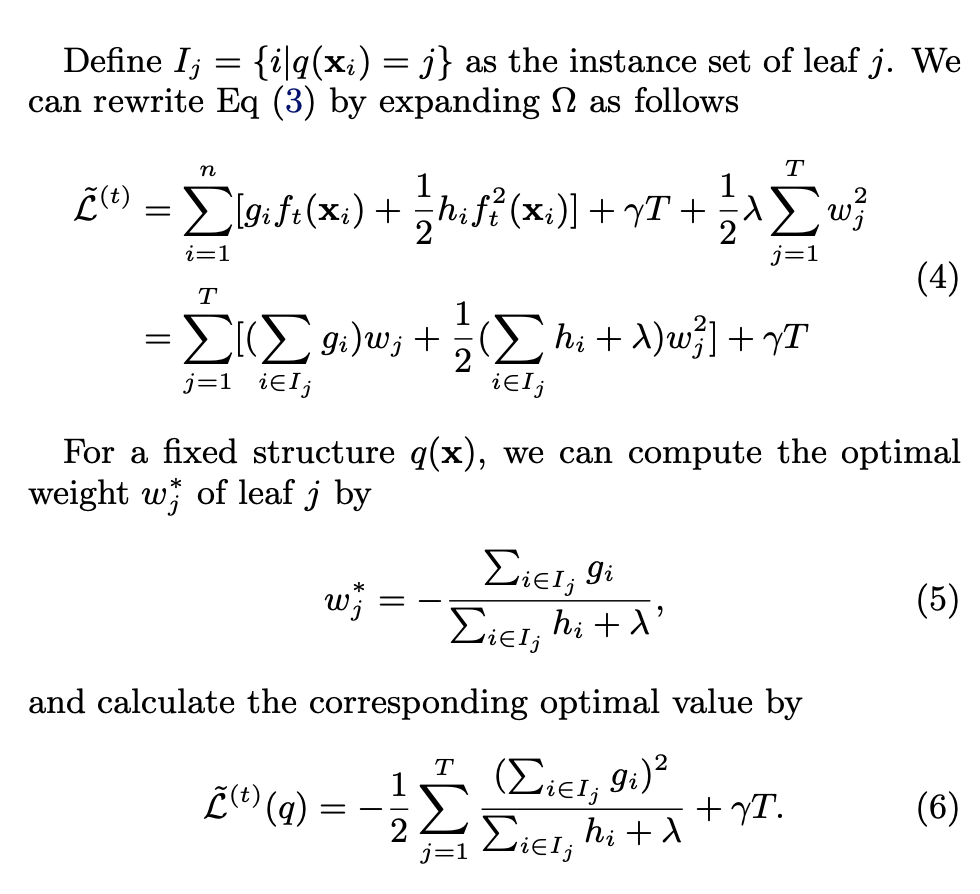

Ответ здесь https://arxiv.org/pdf/1603.02754